# Lab session 2: Dimensionality Reduction using Gaussian Processes

Source: [Gaussian Process Summer School 2015](http://gpss.cc/gpss15/)

The aim of this lab session is to get us started with GPy Library. The current draft of the online documentation of GPy is available from [this page](http://gpy.readthedocs.org/en/latest/). We will focus on three aspects of GPs: the kernel, the random sample paths and the GP regression model.

Requirements:
* [GPy](https://github.com/SheffieldML/GPy): Installation instructions available on the homepage.
* [Scipy Stack](https://www.scipy.org/index.html): This includes numpy, matplotlib and Ipython. Installation can be done using `pip`:
```
(sudo) pip install numpy --upgrade
(sudo) pip install jupyter --upgrade
(sudo) pip install matplotlib --upgrade
(sudo) pip install ipython[all] --upgrade
```
The `sudo` is optional if you want to have installation in the root folder when working in the Linux operating system. It should not be used for Anaconda or when working in the Windows operating system.

* [Anaconda](https://www.continuum.io/downloads): Necessary for Windows, optional for Linux.

For Windows Operating System:
* Install Anaconda by downloading from this [link](https://www.continuum.io/downloads#windows).
* Install GPy by opening the Command Prompt window and typing the following command:
```
pip install GPy
```
* All the dependencies required for running the code are either available in Anaconda or installed using GPy.

In [16]:
# import python modules
import GPy
import string
import numpy as np
from GPy.util import pca
from matplotlib import pyplot as plt

# call matplotlib with the inline command to make plots appear within the browser
%matplotlib inline

The following code is utility functions for plotting and to prepare the bigger models for later usage. If you are interested, you can have a look, but this is not essential.

In [14]:
colors = ["#3FCC94", "#DD4F23", "#C6D63B", "#D44271", 
          "#E4A42C", "#4F9139", "#6DDA4C", "#85831F", 
          "#B36A29", "#CF4E4A"]
def plot_model(X, which_dims, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    X = X[:,which_dims]
    
    ulabs = []
    for lab in labels:
        if not lab in ulabs:
            ulabs.append(lab)
            pass
        pass
    for i, lab in enumerate(ulabs):
        ax.scatter(*X[labels==lab].T,marker='o',color=colors[i],label=lab)
        pass
    pass

## 1 Download Data

For this lab, we use a dataset `digits.npy` containing all handwritten digits from $0 \cdots 9$ handwritten, provided by deCampos et al. [2009]. We will only use some of the digits for the demonstrations in this lab class, but you can edit the code below to select different subsets of the digit data as you wish.

In [3]:
# choose subset of digits to work on
which = [0,1,2,6,7,9] 
data = np.load('digits.npy')
data = data[which,:,:,:]
num_classes, num_samples, height, width = data.shape

# get the digits data and corresponding labels
Y = data.reshape((data.shape[0]*data.shape[1],data.shape[2]*data.shape[3]))
lbls = np.array([[l]*num_samples for l in which]).reshape(Y.shape[0], 1)
labels = np.array([[str(l)]*num_samples for l in which])

You can try to plot some of the digits using `plt.matshow` (the digit images have size `16x16`).

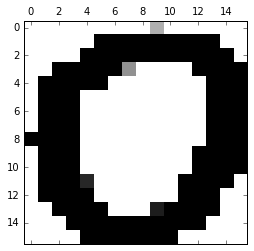

In [6]:
plt.matshow(Y[0,:].reshape((height,width)), cmap=plt.cm.gray)

## 2 Principal Component Analysis

Principal component analysis (PCA) finds a rotation of the observed outputs, such that the rotated principal component (PC) space maximizes the variance of the data observed, sorted from most to least important (most to least variable in the corresponding PC).

In [7]:
# it is important to normalize the data
Yn = Y-Y.mean()

Now let’s run PCA on the reshaped dataset $\mathbf{Y}$:

In [18]:
p = pca.PCA(Yn) # create PCA class with digits dataset

The resulting plota will show the lower dimensional representation of the digits in 2 dimensions,

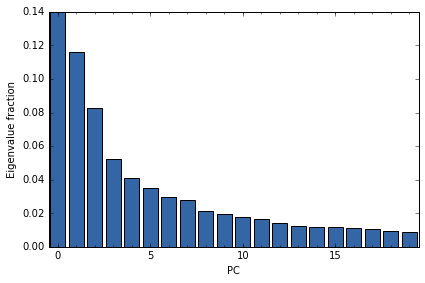

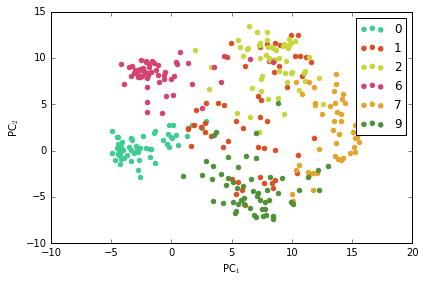

In [19]:
# plot first 20 eigenvalue fractions
p.plot_fracs(20) 

# plot the latent space by PCA
p.plot_2d(Y,labels=labels.flatten(), colors=colors)
plt.legend()

## 3 Gaussian Process Latent Variable Model

Gaussian Process Latent Variable Model (GP-LVM) embeds PCA into Gaussian process framework. In the Gaussian Process, any covariance function can be used. One example is the automatic relevance determination (ARD) linear kernel:

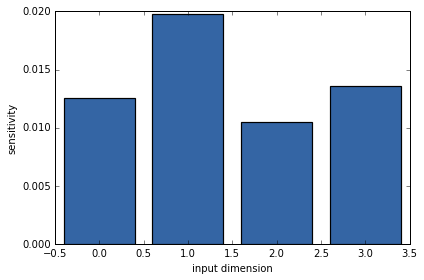

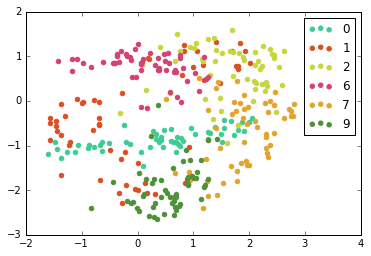

In [20]:
# set latent dimensions to use
input_dim = 4 

# define covariance function to be used
kernel = GPy.kern.Linear(input_dim, ARD=True)

# setup the GPLVM model
m = GPy.models.GPLVM(Yn, input_dim=input_dim, kernel=kernel)

# optimize for 1000 iterations
m.optimize(messages=1, max_iters=1000) 

# visualize the ARD kernel parameters
m.kern.plot_ARD()

# visualize the two most significant dimensions
plot_model(m.X, m.linear.variances.argsort()[-2:], labels.flatten())
plt.legend()

For the linear covariance, these latent points can be optimized with an eigenvalue problem, but generally, for non-linear covariance functions, we have to use gradient based optimization.

### Exercise 1

a) How do your linear solutions differ between PCA and GPLVM with a linear kernel? Look at the plots and also try and consider how the linear ARD parameters compare to the eigenvalues of the principal components.

b) The next step is to use a non-linear mapping between inputs $\mathbf{X}$ and ouputs $\mathbf{Y}$ by selecting the RBF (`GPy.kern.rbf`) covariance function. 

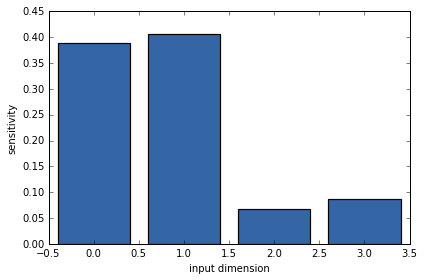

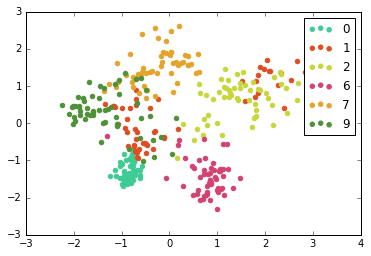

In [25]:
# set latent dimensions to use
input_dim = 4 

# define covariance function to be used
kernel = GPy.kern.RBF(input_dim, ARD=True)

# setup the GPLVM model
m = GPy.models.GPLVM(Yn, input_dim=input_dim, kernel=kernel)

# optimize for 1000 iterations
m.optimize(messages=1, max_iters=1000) 

# visualize the ARD kernel parameters
m.kern.plot_ARD()

# visualize the two most significant dimensions
plot_model(m.X, m.rbf.lengthscale.argsort()[:2], labels.flatten())
plt.legend()

c) How does the nonlinear model differe from the linear model? Are there digits that the GPLVM with an exponentiated quadratic covariance can separate, which PCA is not able to?

d) Try modifying the covariance function and running the model again. For example you could try a combination of the linear and exponentiated quadratic covariance function or the Matern 5/2. If you run into stability problems try initializing the covariance function parameters differently.

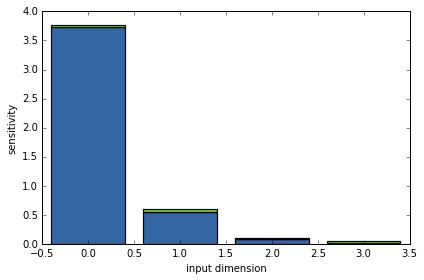

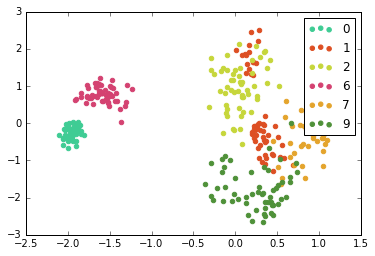

In [28]:
# set latent dimensions to use
input_dim = 4 

# define covariance function to be used
kernel = GPy.kern.Matern52(input_dim, ARD=True)+GPy.kern.Linear(input_dim, ARD=True)+GPy.kern.RBF(input_dim, ARD=True)

# setup the GPLVM model
m = GPy.models.GPLVM(Yn, input_dim=input_dim, kernel=kernel)

# optimize for 1000 iterations
m.optimize(messages=1, max_iters=1000) 

# visualize the ARD kernel parameters
m.kern.plot_ARD()

# visualize the two most significant dimensions
plot_model(m.X, m.sum.Mat52.lengthscale.argsort()[:2], labels.flatten())
plt.legend()

## References

C. M. Bishop. Pattern recognition and machine learning, volume 1. springer New York, 2006.

T. de Campos, B. R. Babu, and M. Varma. Character recognition in natural images. VISAPP 2009.

N. D. Lawrence. Probabilistic non-linear principal component analysis with Gaussian process latent variable models. In Journal of Machine Learning Research 6, pp 1783--1816, 2005